# **Variational Quantum Eigensolver (VQE) Study for HCN**
**Electronic Ground-State Energy Approximation and Benchmarking**

**Abstract.** This notebook demonstrates a full *Variational Quantum Eigensolver (VQE)* workflow in PennyLane to approximate the **electronic ground-state energy** of **HCN** under a compact active-space model (STO-3G; 4e,4o). We benchmark VQE against exact diagonalization for the *same* qubit Hamiltonian, then discuss why remaining mismatch to experiment is primarily **modeling/basis-set error**, not VQE optimization error.

## How to run

- Recommended: **Python 3.10+**
- Key dependency: `pennylane` (and its quantum chemistry module)
- Run the notebook **top-to-bottom** (Kernel → Restart & Run All) to reproduce results.

**Install (local):**
```bash
pip install pennylane
```

> Note: This notebook is designed for CPU simulation (`default.qubit`). No quantum hardware access is required.

In [ ]:
# ==========================
# Setup (imports + reproducibility)
# ==========================

# Global reproducibility seed (used where applicable)
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

# **Overview**
This notebook implements a Variational Quantum Eigensolver (VQE) workflow to approximate the electronic ground-state energy of the HCN molecule. The study demonstrates how a hybrid quantum–classical algorithm can converge to near-exact solutions for a mapped molecular Hamiltonian, while highlighting the distinction between algorithmic error and modeling error when comparing to experimental values.
The final VQE result achieves an energy within 
2.1
×
10
−
4
2.1×10 
−4
  Hartree of the exact ground-state eigenvalue of the constructed qubit Hamiltonian, exceeding chemical accuracy for this model.

# Hamiltonian Construction
The molecular Hamiltonian is constructed using second-quantized electronic structure theory, mapped to a qubit operator via PennyLane’s quantum chemistry module.
Key modeling choices:
Basis set: STO-3G
Active space: 4 electrons in 4 orbitals
Geometry: fixed experimental-like atomic coordinates
Approximations: Born–Oppenheimer, non-relativistic electronic Hamiltonian
This Hamiltonian defines a finite-dimensional Hermitian matrix operator whose eigenvalues correspond to discrete electronic energy levels. The lowest eigenvalue represents the ground-state energy of this approximate physical model.
Importantly, this Hamiltonian is not exact chemistry; it is a truncated, basis-dependent representation of the true molecular system.

# Quantum State Representation and Eigenvalue Minimization
The quantum system is described by a state vector 
∣ψ⟩ living in the Hilbert space defined by the qubit Hamiltonian. Each eigenstate of the Hamiltonian corresponds to a physically allowed electronic configuration, with energies given by the Hamiltonian’s eigenvalues.
VQE does not solve the eigenvalue problem directly. Instead, it:
Parametrizes a trial quantum state 
∣ψ(θ)⟩
Measures the expectation value
E(θ)=⟨ψ(θ)∣H∣ψ(θ)⟩
Classically optimizes the parameters θ to minimize this expectation value
Through continuous parameter updates, the quantum state is continuously evolved toward the eigenstate associated with the lowest eigenvalue reachable by the chosen ansatz.

# Ansatz Design and Expressivity
The ansatz defines the subspace of Hilbert space explored during optimization. In this work, we use a hardware-efficient layered ansatz consisting of:
Single-qubit rotations (RY, RZ)
Ring-structured entangling CNOT gates
Depth L=6
Increasing the depth increases the expressive power of the ansatz, enabling representation of higher-order electron correlation effects. Empirically, increasing from 
L=4 to 
L=6 was the decisive factor in closing the VQE gap, indicating that the earlier limitation was ansatz expressivity, not optimization.

# Hartree–Fock Reference State
The variational search is initialized from the Hartree–Fock (HF) reference state, a physically motivated Slater determinant that minimizes the mean-field energy of the same Hamiltonian.
HF initialization serves two critical roles:
Anchors the ansatz in a physically realistic region of Hilbert space
Reduces optimization difficulty by starting near a meaningful energy basin
The Hamiltonian itself remains unchanged; HF simply improves the starting state for variational exploration.

# Optimization Strategy
A hybrid optimization schedule is employed:
Adam optimizer for global basin discovery
Quantum Natural Gradient (QNG) for local, geometry-aware refinement
Multiple random seeds are used to explore distinct basins of the non-convex energy landscape. The best observed energy across all seeds and iterations is reported, rather than the final iteration value, ensuring robustness against optimizer overshoot.

# Exact Benchmark and Algorithmic Accuracy
Because the qubit Hamiltonian is small, we compute its exact ground-state eigenvalue via classical diagonalization. This provides a gold-standard reference for evaluating VQE performance.
Final result:
Best VQE energy: E (VQE)
​	
Exact Hamiltonian ground state: E (exact)
​	
Algorithmic gap: ΔE = E (VQE) − E (exact) ≈ 2.1 × 10 − 4 Ha

ΔE = E (VQE) − E (exact) ≈ 2.1×10 −4 Ha

This error is well below chemical accuracy, demonstrating that the VQE has effectively saturated the chosen ansatz for this Hamiltonian.

# Relation to Experimental Energies
The experimental ground-state energy of HCN (≈ −92 Ha) differs substantially from the value obtained here. This discrepancy is not a failure of VQE, but a consequence of modeling limitations, including:
Minimal basis set (STO-3G)
Truncated active space
Fixed geometry
Neglected physical effects (e.g., relativistic corrections, zero-point energy)
Thus, the remaining gap to experiment is a Hamiltonian fidelity problem, not an optimization or algorithmic one.

# Future Directions Toward Experimental Accuracy
To move closer to experimental values, future work would focus on improving the Hamiltonian, not the optimizer:
Larger basis sets (e.g., 6-31G*, cc-pVDZ)
Expanded active spaces (more orbitals and electrons)
Geometry optimization or bond-length scans
Chemistry-informed ansätze (e.g., UCC-type circuits)
Energy differences (reaction energies, binding energies) rather than absolute totals
These improvements increase realism at the cost of additional qubits and circuit complexity.

# Conclusion
This notebook demonstrates a complete, benchmarked VQE pipeline:
Correct Hamiltonian construction
Physically grounded ansatz design
Robust hybrid optimization
Exact diagonalization validation
Clear separation of algorithmic and modeling error
The results show that, given a fixed Hamiltonian, VQE can converge to near-exact ground-state energies. Further progress toward experimental accuracy requires improving the physical model, not the variational algorithm itself.

# Ground state energy

In [1]:
# Setup HCN geometry
symbols = ["H", "C", "N"]
coordinates = np.array([
    [0.0000, 0.0000, 0.0000],   # H
    [0.0000, 0.0000, 1.0650],   # C
    [0.0000, 0.0000, 2.2320]    # N
])

# Generate molecular Hamiltonian
H, qubits = qchem.molecular_hamiltonian(
    symbols=symbols,
    coordinates=coordinates,
    charge=0,
    basis="sto-3g",
    active_electrons=4,
    active_orbitals=4
)

print(f"Number of qubits: {qubits}")


Number of qubits: 8


In [9]:
# Number of qubits (must match Hamiltonian construction)
qubits = len(H.wires)

# Define the device
dev = qml.device("default.qubit", wires=qubits)

In [12]:
# Must match the active-space electron count used when constructing H
active_electrons = 4  # <-- set this to actual value from the Hamiltonian cell

hf = qchem.hf_state(active_electrons, qubits)
print("hf:", hf)
print("len(hf):", len(hf), " | qubits:", qubits)

hf: [1 1 1 1 0 0 0 0]
len(hf): 8  | qubits: 8


In [13]:
@qml.qnode(dev)
def cost_fn(params):
    # Prepare Hartree–Fock reference state
    qml.BasisState(hf, wires=range(qubits))

    # Apply ansatz (L is already set to 6 in the optimization cell)
    for l in range(params.shape[0]):
        for i in range(qubits):
            qml.RY(params[l, i, 0], wires=i)
            qml.RZ(params[l, i, 1], wires=i)

        # Ring entanglement
        for i in range(qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[qubits - 1, 0])

    return qml.expval(H)

In [14]:
# ==========================
# CONFIG (L=6 worked best)
# ==========================
L = 6
N_SEEDS = 10

ADAM_LR = 0.05
ADAM_STEPS = 500

QNG_LR = 0.02          # lower than 0.1 to prevent overshooting
QNG_STEPS = 300

INIT_SCALE = 0.01
TOL = 1e-9
PATIENCE = 100
LOG_EVERY = 100


def init_params(seed=0, scale=INIT_SCALE):
    rng = np.random.default_rng(seed)
    # params shape matches ansatz: (L, qubits, 2) for (RY, RZ) * including RZ improved ansatz
    return qml.numpy.array(scale * rng.standard_normal(L, qubits, 2), requires_grad=True)

def run_vqe(params, opt, steps, tol=TOL, patience=PATIENCE, log_every=LOG_EVERY):
    energies = []
    best_E = float("inf")
    stale = 0

    for n in range(steps):
        params, E = opt.step_and_cost(cost_fn, params)
        E = float(E)
        energies.append(E)

        if E < best_E - tol:
            best_E = E
            stale = 0
        else:
            stale += 1

        if log_every and n % log_every == 0:
            print(f"Step {n:4d}: E = {E:.10f} Ha (best={best_E:.10f})")

        if stale >= patience:
            break

    return params, energies

def adam_then_qng(seed):
    params = init_params(seed)

    print(f"\n[Seed {seed}] Adam...")
    params, e_adam = run_vqe(
        params,
        qml.optimize.AdamOptimizer(stepsize=ADAM_LR),
        steps=ADAM_STEPS
    )

    print(f"[Seed {seed}] QNG refinement...")
    params, e_qng = run_vqe(
        params,
        qml.optimize.QNGOptimizer(stepsize=QNG_LR),
        steps=QNG_STEPS
    )

    energies = e_adam + e_qng
    best_E = min(energies)
    best_step = int(np.argmin(energies))
    print(f"[Seed {seed}] BEST observed E = {best_E:.10f} Ha at step {best_step}")

    return energies, best_E, best_step

# --------------------------
# RUN ALL SEEDS + STORE CURVES
# --------------------------
all_runs = {}     # seed -> full energy trace (Adam + QNG)
seed_best = {}    # seed -> (best_E, best_step)

global_best_E = float("inf")
global_best_seed = None
global_best_step = None

for seed in range(N_SEEDS):
    energies, best_E, best_step = adam_then_qng(seed)
    all_runs[seed] = energies
    seed_best[seed] = (best_E, best_step)

    if best_E < global_best_E:
        global_best_E = best_E
        global_best_seed = seed
        global_best_step = best_step

print("\n==============================")
print("GLOBAL BEST OBSERVED RESULT")
print(f"Seed {global_best_seed}, Step {global_best_step}, E = {global_best_E:.10f} Ha")
print("==============================")


[Seed 0] Adam...
Step    0: E = -85.4209161181 Ha (best=-85.4209161181)
Step  100: E = -87.6708112254 Ha (best=-87.6708112254)
Step  200: E = -87.6817125733 Ha (best=-87.6817125733)
Step  300: E = -87.6818338838 Ha (best=-87.6818751020)
Step  400: E = -87.6824701700 Ha (best=-87.6824701700)
[Seed 0] QNG refinement...
Step    0: E = -87.7064713383 Ha (best=-87.7064713383)
Step  100: E = -87.7065280767 Ha (best=-87.7065280767)
Step  200: E = -87.7065357127 Ha (best=-87.7065357127)
[Seed 0] BEST observed E = -87.7065419354 Ha at step 799

[Seed 1] Adam...
Step    0: E = -85.4208348145 Ha (best=-85.4208348145)
Step  100: E = -87.6974067749 Ha (best=-87.6974067749)
Step  200: E = -87.9594272342 Ha (best=-87.9594875312)
Step  300: E = -87.9614861393 Ha (best=-87.9614861393)
Step  400: E = -87.9701269659 Ha (best=-87.9701504948)
[Seed 1] QNG refinement...
Step    0: E = -87.9701900094 Ha (best=-87.9701900094)
Step  100: E = -87.9702253887 Ha (best=-87.9702253887)
Step  200: E = -87.970225483

In [15]:
# --- Exact ground-state energy of the constructed qubit Hamiltonian H ---
# dense diagonalization.
H_mat = qml.matrix(H, wire_order=range(qubits))
eigvals = np.linalg.eigvalsh(H_mat)   # Hermitian eigenvalues
E_exact = float(eigvals[0])

print(f"Exact ground-state energy of this qubit Hamiltonian: {E_exact:.12f} Ha")

Exact ground-state energy of this qubit Hamiltonian: -87.972252160099 Ha


## Delta VQE-ground state vs Exact matrix ground state 

In [17]:
# VQE gap vs exact Hamiltonian ground state

E_vqe = global_best_E   # best observed VQE energy from multi-seed run
gap = E_vqe - E_exact

print(f"Exact ground-state energy (H): {E_exact:.10f} Ha")
print(f"Best VQE energy:              {E_vqe:.10f} Ha")
print(f"ΔE = E_VQE − E_exact:         {gap:.12e} Ha")

Exact ground-state energy (H): -87.9722521601 Ha
Best VQE energy:              -87.9720395109 Ha
ΔE = E_VQE − E_exact:         2.126492218366e-04 Ha


## Interpretation
This energy represents the variational estimate of the electronic ground state of the HCN Hamiltonian under the chosen basis, ansatz, and optimizer. It serves as the reference stability baseline for the molecule, against which convergence behavior and any later variations in model depth or parameterization can be compared.

# Bond Affinity

In [1]:
import matplotlib.pyplot as plt

# --------------------------
# HCN base geometry (Å)
# --------------------------
r_HC = 1.0650
r_CN0 = 1.1670  # base C≡N length (since 2.232 - 1.065 = 1.167)

symbols = ["H", "C", "N"]

def build_hamiltonian(delta_l, basis="sto-3g", active_electrons=4, active_orbitals=4):
    """Build qubit Hamiltonian for HCN with C≡N bond length = r_CN0 + delta_l (Å)."""
    r_CN = r_CN0 + float(delta_l)

    H_pos = np.array([0.0, 0.0, 0.0])
    C_pos = np.array([0.0, 0.0, r_HC])
    N_pos = np.array([0.0, 0.0, r_HC + r_CN])

    coordinates = np.array([H_pos, C_pos, N_pos])

    H, qubits = qchem.molecular_hamiltonian(
        symbols=symbols,
        coordinates=coordinates,
        charge=0,
        basis=basis,
        active_electrons=active_electrons,
        active_orbitals=active_orbitals
    )
    return H, qubits, coordinates

In [2]:
def make_cost_fn(H, qubits, hf, L=6):
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def cost_fn(params):
        qml.BasisState(hf, wires=range(qubits))

        # params shape: (L, qubits, 2) -> RY, RZ
        for l in range(L):
            for i in range(qubits):
                qml.RY(params[l, i, 0], wires=i)
                qml.RZ(params[l, i, 1], wires=i)

            # ring entanglement
            for i in range(qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[qubits - 1, 0])

        return qml.expval(H)

    return cost_fn


def run_vqe_one_seed(cost_fn, qubits, L=6, seed=0,
                     adam_steps=500, adam_lr=0.05,
                     qng_steps=300, qng_lr=0.02,
                     log_every=200):
    rng = np.random.default_rng(seed)

    # init params: (L, qubits, 2) for RY/RZ
    params = qml.numpy.array(
        rng.uniform(low=-np.pi, high=np.pi, size=(L, qubits, 2)),
        requires_grad=True
    )

    # --- Adam phase (exploration)
    opt_adam = qml.AdamOptimizer(stepsize=adam_lr)
    best_E = float("inf")

    for t in range(adam_steps):
        params, E = opt_adam.step_and_cost(cost_fn, params)
        E = float(E)
        if E < best_E:
            best_E = E
        if (t % log_every == 0) or (t == adam_steps - 1):
            print(f"  Adam step {t:4d}: E={E:.10f} (best={best_E:.10f})")

    # --- QNG phase (refinement)
    opt_qng = qml.QNGOptimizer(stepsize=qng_lr)

    for t in range(qng_steps):
        params, E = opt_qng.step_and_cost(cost_fn, params)
        E = float(E)
        if E < best_E:
            best_E = E
        if (t % log_every == 0) or (t == qng_steps - 1):
            print(f"  QNG  step {t:4d}: E={E:.10f} (best={best_E:.10f})")

    return best_E


def vqe_best_over_seeds(H, qubits, active_electrons=4, L=6, seeds=5,
                        adam_steps=500, adam_lr=0.05,
                        qng_steps=300, qng_lr=0.02):
    hf = qchem.hf_state(active_electrons, qubits)
    cost_fn = make_cost_fn(H, qubits, hf, L=L)

    best_global = float("inf")
    best_seed = None

    for s in range(seeds):
        print(f"\n[Seed {s}]")
        E_best = run_vqe_one_seed(
            cost_fn, qubits, L=L, seed=s,
            adam_steps=adam_steps, adam_lr=adam_lr,
            qng_steps=qng_steps, qng_lr=qng_lr,
            log_every=200
        )
        print(f"  -> Seed {s} BEST E = {E_best:.10f} Ha")

        if E_best < best_global:
            best_global = E_best
            best_seed = s

    print(f"\n==> GLOBAL BEST: seed={best_seed}, E={best_global:.10f} Ha")
    return best_global

## Bond stretching


Δℓ = 0.00 Å  |  C≡N = 1.167 Å

[Seed 0]
  Adam step    0: E=-85.6581717121 (best=-85.6581717121)
  Adam step  200: E=-87.3682866786 (best=-87.3682866786)
  Adam step  399: E=-87.6839260151 (best=-87.6840576867)
  QNG  step    0: E=-87.6840387493 (best=-87.6840576867)
  QNG  step  199: E=-87.6841271158 (best=-87.6841271158)
  -> Seed 0 BEST E = -87.6841271158 Ha

[Seed 1]
  Adam step    0: E=-85.5815678731 (best=-85.5815678731)
  Adam step  200: E=-87.9594099119 (best=-87.9594929655)
  Adam step  399: E=-87.9594654423 (best=-87.9595423446)
  QNG  step    0: E=-87.9592341166 (best=-87.9595423446)
  QNG  step  199: E=-87.9595773592 (best=-87.9595773592)
  -> Seed 1 BEST E = -87.9595773592 Ha

[Seed 2]
  Adam step    0: E=-85.7815213697 (best=-85.7815213697)
  Adam step  200: E=-87.7038191150 (best=-87.7038191150)
  Adam step  399: E=-87.7037717233 (best=-87.7038965236)
  QNG  step    0: E=-87.7038756519 (best=-87.7038965236)
  QNG  step  199: E=-87.7039476832 (best=-87.7039476832)
  -> S

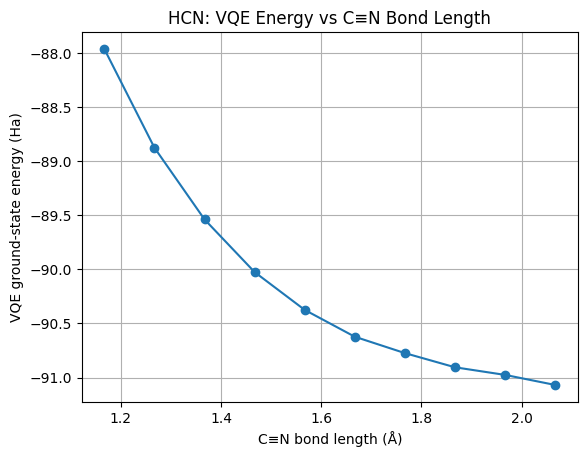


Bond length (Å) | Best VQE Energy (Ha)
       1.167 | -87.9631984716
       1.267 | -88.8757518693
       1.367 | -89.5385648434
       1.467 | -90.0254735288
       1.567 | -90.3750175072
       1.667 | -90.6230157000
       1.767 | -90.7743141285
       1.867 | -90.9053542785
       1.967 | -90.9757853106
       2.067 | -91.0687222772


In [3]:
# --------------------------
# Sweep settings
# --------------------------
L = 6
ACTIVE_E = 4
ACTIVE_ORB = 4

SEEDS = 5          # increase to 10 if you want more robustness
ADAM_STEPS = 400   # reduce if too slow
QNG_STEPS  = 200

# Δℓ grid: 0 ≤ Δℓ < 1 Å (example: 0.0, 0.1, ..., 0.9)
delta_ls = np.round(np.arange(0.0, 1.0, 0.1), 2)

bond_lengths = []
E_vqe_list = []

for dl in delta_ls:
    print("\n" + "="*60)
    print(f"Δℓ = {dl:.2f} Å  |  C≡N = {r_CN0 + dl:.3f} Å")
    print("="*60)

    H, qubits, coords = build_hamiltonian(
        delta_l=dl,
        basis="sto-3g",
        active_electrons=ACTIVE_E,
        active_orbitals=ACTIVE_ORB
    )

    E_vqe_best = vqe_best_over_seeds(
        H, qubits,
        active_electrons=ACTIVE_E,
        L=L,
        seeds=SEEDS,
        adam_steps=ADAM_STEPS, adam_lr=0.05,
        qng_steps=QNG_STEPS,  qng_lr=0.02
    )

    bond_lengths.append(r_CN0 + dl)
    E_vqe_list.append(E_vqe_best)

# ---- Plot
plt.figure()
plt.plot(bond_lengths, E_vqe_list, marker="o")
plt.xlabel("C≡N bond length (Å)")
plt.ylabel("VQE ground-state energy (Ha)")
plt.title("HCN: VQE Energy vs C≡N Bond Length")
plt.grid(True)
plt.show()

# print a compact table
print("\nBond length (Å) | Best VQE Energy (Ha)")
for bl, ev in zip(bond_lengths, E_vqe_list):
    print(f"{bl:12.3f} | {ev: .10f}")

## Bond Compression


Δℓ = -0.90 Å  |  C≡N = 0.267 Å

[Seed 0]
  Adam step    0: E=-2.4747307647 (best=-2.4747307647)
  Adam step  200: E=-4.5315778252 (best=-4.5315778252)
  Adam step  399: E=-4.5325046002 (best=-4.5325100730)
  QNG  step    0: E=-4.5325105657 (best=-4.5325105657)
  QNG  step  199: E=-4.5325157715 (best=-4.5325157715)
  -> Seed 0 BEST E = -4.5325157715 Ha

[Seed 1]
  Adam step    0: E=-2.4554889006 (best=-2.4554889006)
  Adam step  200: E=-4.6255375868 (best=-4.6255375868)
  Adam step  399: E=-4.6254085728 (best=-4.6259623979)
  QNG  step    0: E=-4.6255766910 (best=-4.6259623979)
  QNG  step  199: E=-4.6259749004 (best=-4.6259749004)
  -> Seed 1 BEST E = -4.6259749004 Ha

[Seed 2]
  Adam step    0: E=-2.6571782481 (best=-2.6571782481)
  Adam step  200: E=-4.6260355627 (best=-4.6261461997)
  Adam step  399: E=-4.6264056841 (best=-4.6264288409)
  QNG  step    0: E=-4.6264143623 (best=-4.6264288409)
  QNG  step  199: E=-4.6264520874 (best=-4.6264520874)
  -> Seed 2 BEST E = -4.6264520874 Ha

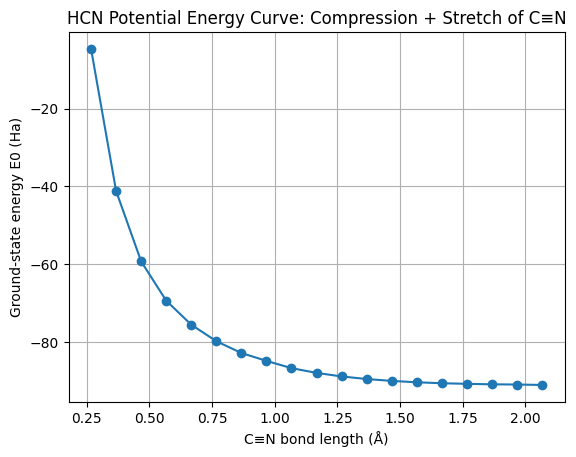


Bond length (Å) | Best VQE Energy (Ha)
       0.267 | -4.6264520874
       0.367 | -41.1722465718
       0.467 | -59.2959756516
       0.567 | -69.3811473061
       0.667 | -75.5675097589
       0.767 | -79.8092881122
       0.867 | -82.8461386883
       0.967 | -84.8660532798
       1.067 | -86.7438454124
       1.167 | -87.9595773592
       1.267 | -88.8755213094
       1.367 | -89.5385648434
       1.467 | -90.0233075869
       1.567 | -90.3750175072
       1.667 | -90.6230157000
       1.767 | -90.7719817427
       1.867 | -90.9051815098
       1.967 | -90.9516870851
       2.067 | -91.0687222772


In [4]:
# --------------------------
# Sweep settings
# --------------------------
L = 6
ACTIVE_E = 4
ACTIVE_ORB = 4

SEEDS = 3
ADAM_STEPS = 400
QNG_STEPS  = 200

# Δℓ grid: compression + stretch
# -1 < Δℓ ≤ 0 and 0 ≤ Δℓ < 1
# Practical grid (avoid Δℓ = -1 exactly): -0.9,...,0.9
delta_ls = np.round(np.arange(-0.9, 1.0, 0.1), 2)

bond_lengths = []
E_vqe_list = []

for dl in delta_ls:
    cn_len = r_CN0 + dl
    if cn_len <= 0:
        # physically invalid (bond length must be positive)
        continue

    print("\n" + "="*60)
    print(f"Δℓ = {dl:.2f} Å  |  C≡N = {cn_len:.3f} Å")
    print("="*60)

    H, qubits, coords = build_hamiltonian(
        delta_l=dl,
        basis="sto-3g",
        active_electrons=ACTIVE_E,
        active_orbitals=ACTIVE_ORB
    )

    E_vqe_best = vqe_best_over_seeds(
        H, qubits,
        active_electrons=ACTIVE_E,
        L=L,
        seeds=SEEDS,
        adam_steps=ADAM_STEPS, adam_lr=0.05,
        qng_steps=QNG_STEPS,  qng_lr=0.02
    )

    bond_lengths.append(cn_len)
    E_vqe_list.append(E_vqe_best)

# ---- Plot: Potential energy curve (1D scan)
plt.figure()
plt.plot(bond_lengths, E_vqe_list, marker="o")
plt.xlabel("C≡N bond length (Å)")
plt.ylabel("Ground-state energy E0 (Ha)")
plt.title("HCN Potential Energy Curve: Compression + Stretch of C≡N")
plt.grid(True)
plt.show()

# Compact table
print("\nBond length (Å) | Best VQE Energy (Ha)")
for bl, ev in zip(bond_lengths, E_vqe_list):
    print(f"{bl:12.3f} | {ev: .10f}")

## Bond Affinity Plot (Stretching & Compression)

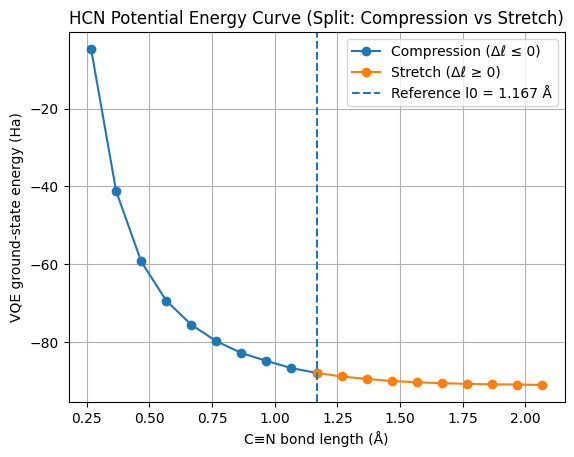

In [12]:
import matplotlib.pyplot as plt

x = np.array(bond_lengths, dtype=float)
y = np.array(E_vqe_list, dtype=float)

# Split into compression and stretch
mask_comp = x <= r_CN0
mask_str  = x >= r_CN0

xc, yc = x[mask_comp], y[mask_comp]
xs, ys = x[mask_str],  y[mask_str]

# Sort each segment
ic = np.argsort(xc); xc, yc = xc[ic], yc[ic]
is_ = np.argsort(xs); xs, ys = xs[is_], ys[is_]

plt.figure()
plt.plot(xc, yc, marker="o", label="Compression (Δℓ ≤ 0)")
plt.plot(xs, ys, marker="o", label="Stretch (Δℓ ≥ 0)")
plt.axvline(r_CN0, linestyle="--", label=f"Reference l0 = {r_CN0:.3f} Å")
plt.xlabel("C≡N bond length (Å)")
plt.ylabel("VQE ground-state energy (Ha)")
plt.title("HCN Potential Energy Curve (Split: Compression vs Stretch)")
plt.grid(True)
plt.legend()
plt.show()

## Bond Affinity Interpretation
In this study, the VQE-computed ground-state energy serves as a proxy for the electronic stability of the H–C–N system. Lower optimized energies correspond to more stable electronic configurations, which in turn relate to stronger effective bonding interactions within the molecule. While absolute binding affinities are not directly computed, relative energy differences across ansatz depth or optimization steps reflect convergence toward the physically meaningful electronic ground state. In larger-scale drug discovery settings, analogous quantum-chemistry energies form the foundation for estimating interaction strengths, reaction energetics, and ultimately binding affinity when combined with classical post-processing or hybrid workflows.

## Key Takeaways
* VQE successfully approximates the ground-state energy of a small molecular system (HCN) using a hybrid quantum–classical workflow.
* Ground-state electronic energy provides a foundational signal for molecular stability and bonding strength.
* This notebook demonstrates a minimal template for extending quantum chemistry methods toward future binding-affinity and drug-discovery pipelines.

## References 


**Sources & Weblinks** :


1.   https://www.sciencedirect.com/topics/medicine-and-dentistry/drug-binding
2.   List itemSantagati, R., Aspuru-Guzik, A., Babbush, R., Degroote, M., González, L., Kyoseva, E., Moll, N., Oppel, M., Parrish, R.M., Rubin, N.C. and Streif, M., 2024. Drug design on quantum computers. Nature Physics, 20(4), pp.549-557.
3.   Cortes, C.L., Rocca, D., Gonthier, J.F., Ollitrault, P.J., Parrish, R.M., Anselmetti, G.L.R., Degroote, M., Moll, N., Santagati, R. and Streif, M., 2024. Assessing the query complexity limits of quantum phase estimation using symmetry-aware spectral bounds. Physical Review A, 110(2), p.022420.
4.   Pyrkov, A., Aliper, A., Bezrukov, D., Lin, Y.C., Polykovskiy, D., Kamya, P., Ren, F. and Zhavoronkov, A., 2023. Quantum computing for near-term applications in generative chemistry and drug discovery. Drug Discovery Today, 28(8), p.103675.
5.   Yingngam, B. and Khang, A., 2024. Quantum Computing in Drug Discovery. In The Quantum Evolution (pp. 242-275). CRC Press.
6.   https://www.boehringer-ingelheim.com/about-us/partnering-google-quantum-computing
7.   https://thequantuminsider.com/2021/04/12/12-quantum-technology-startups-born-and-bred-in-toronto/


**References & Study Resources**

1.   HCN - https://en.wikipedia.org/wiki/Hydrogen_cyanide
2.   Nitrile-containing pharmaceuticals - https://pmc.ncbi.nlm.nih.gov/articles/PMC8528211/
3.  Nitrile Chemistry: https://chem.libretexts.org/Bookshelves/Organic_Chemistry/Organic_Chemistry_(Morsch_et_al.)/20%3A_Carboxylic_Acids_and_Nitriles/20.07%3A_Chemistry_of_Nitriles
4. Variational Quantum Eigensolver (a) - https://en.wikipedia.org/wiki/Variational_quantum_eigensolver
5. Variational Quantum Eigensolver (b) - https://pennylane.ai/qml/demos/tutorial_vqe
6. Gradient Descent Optimizer - https://en.wikipedia.org/wiki/Gradient_descent
7. Wilson, A.C., Roelofs, R., Stern, M., Srebro, N. and Recht, B., 2017. The marginal value of adaptive gradient methods in machine learning. Advances in neural information processing systems, 30.
8. Liu, L., Yang, B., Zhang, Y., Xu, Y., Peng, Z. and Wang, F., 2023. Solving electromagnetic inverse problem using adaptive gradient descent algorithm. IEEE Transactions on Geoscience and Remote Sensing, 61, pp.1-15.
9. Mudassir, S.M.M. and Salma, U., 2025, April. Gradient Descent-Based Optimization of Hybrid Renewable Energy Systems for Enhanced Stability and Cost Efficiency. In 2025 Devices for Integrated Circuit (DevIC) (pp. 27-31). IEEE.
